# First we try and recreate the original Jurcsik and Kovacs paper equation

In [ ]:
import blink_util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import RocCurveDisplay

data = pd.read_csv("Jurcsik_Kovacs_1996_table1.csv")


# data filter

df = data.drop(columns=["star_name","shifted_data","A0", "N"])

df

,period,sigma,A1,phi1,A2,phi2,A3,phi3,A4,phi4,...,phi11,A12,phi12,A13,phi13,a14,phi14,A15,phi15,metallicity
0,0.442266,0.0091,0.3218,0.0179,0.1803,2.6140,0.1057,5.4850,0.0590,2.0787,...,5.5635,0.0044,1.9820,0.0058,4.6203,0.0051,0.7701,0.0044,3.6286,-0.06
1,0.722753,0.0155,0.3358,1.6476,0.1720,5.9663,0.1134,4.0763,0.0617,2.5336,...,1.7614,0.0006,1.7596,0.0013,0.5223,0.0011,5.6820,0.0012,4.6372,-1.69
2,0.616915,0.0141,0.2000,1.5871,0.0795,5.8195,0.0399,3.9177,0.0192,2.1835,...,3.6049,0.0008,1.2567,0.0009,5.3117,0.0007,3.8731,0.0008,1.9359,-0.92
3,0.574337,0.0184,0.3241,2.9349,0.1425,1.9110,0.1110,1.1494,0.0745,0.5286,...,4.1754,0.0048,3.5231,0.0061,3.0121,0.0056,2.3907,0.0050,1.7239,-1.39
4,0.459303,0.0180,0.4646,1.8951,0.2167,6.0193,0.1610,4.1492,0.0980,2.3481,...,2.3529,0.0080,0.6458,0.0050,5.6980,0.0048,2.3401,0.0009,0.6272,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.0135,0.3281,2.9453,0.1658,1.9827,0.1162,1.4013,0.0748,0.8343,...,4.8732,0.0038,4.3968,0.0046,3.8138,0.0050,3.2229,0.0051,2.6125,-1.15
80,0.475607,0.0139,0.3756,1.3720,0.2054,5.1373,0.1310,2.9590,0.0938,0.8321,...,3.3662,0.0046,0.6953,0.0034,4.6167,0.0018,2.0494,0.0011,5.7768,-0.60
81,0.525791,0.0377,0.4131,4.8677,0.1731,5.7203,0.1417,0.3700,0.1022,1.5990,...,2.7926,0.0102,3.8922,0.0096,5.0910,0.0088,0.0597,0.0077,1.3509,-1.54
82,0.656908,0.0184,0.2718,0.7286,0.1335,4.0737,0.0822,1.4576,0.0426,5.1255,...,0.8733,0.0028,4.4377,0.0014,1.3375,0.0010,4.4196,0.0009,1.7312,-1.02


# We now evaluate the relationship between parameters
We'll begin by setting up a new DF with the appropriate parameters

## $R_{mn}​=A_m/​A_n​​ $
We want the ratios between alphas so that our results are distance independent

In [182]:
jk_df = pd.DataFrame() # This is the dataframe we'll use to replicate Jurcsik and Kovacs' results with Phi31
jk_df["period"] = df["period"]


def append_amp_ratios(original_df, new_df, filter=None):
    # get amp ratios ex. A1/A2, A1/A3 etc.
    alpha_filter = (original_df[filter] if filter 
                    else original_df.filter(regex="A", axis=1))
    alpha_cols = sorted(alpha_filter.columns, key=lambda x: int(x[1:]))


    for alpha in reversed(alpha_cols):
        lower_alphas = [a for a in alpha_cols if int(a[1:]) < int(alpha[1:])]

        for alpha_denom in lower_alphas:
            ratio_name = f"R_{alpha[1:]}/{alpha_denom[1:]}"
            new_df[ratio_name] = (
                alpha_filter[alpha].to_numpy() / alpha_filter[alpha_denom].to_numpy())

append_amp_ratios(df, jk_df, filter=["A1","A2","A3"])

jk_df

,period,R_3/1,R_3/2,R_2/1
0,0.442266,0.328465,0.586245,0.560286
1,0.722753,0.337701,0.659302,0.512210
2,0.616915,0.199500,0.501887,0.397500
3,0.574337,0.342487,0.778947,0.439679
4,0.459303,0.346535,0.742963,0.466423
...,...,...,...,...
79,0.557657,0.354160,0.700844,0.505334
80,0.475607,0.348775,0.637780,0.546858
81,0.525791,0.343016,0.818602,0.419027
82,0.656908,0.302428,0.615730,0.491170


## Computing $\phi_{mn}$
We get the values for phase difference parameters and measure their weights

In [183]:
def append_phi_diff(original_df, new_df,filter=None):
    

    phi_filter = (original_df.filter(filter) if filter else original_df.filter(regex='phi'))

    for phi_n1 in phi_filter.columns:

        for phi_n2 in phi_filter.drop(columns=[phi_n1]).columns:
            phi_name = f"phi{phi_n2[3:]}{phi_n1[3:]}"

            phi_n1_row = phi_filter[phi_n1].to_numpy()
            phi_n2_row = phi_filter[phi_n2].to_numpy()
            

            coef = int(phi_n2[3:])

            # append phase differences
            new_df[phi_name] = blink_util.twopi_normalize(phi_n1_row, phi_n2_row, coef=coef)


append_phi_diff(df, jk_df, filter=["phi1","phi2","phi3"])

jk_df["metallicity"] = df["metallicity"]

jk_df

,period,R_3/1,R_3/2,R_2/1,phi21,phi31,phi12,phi32,phi13,phi23,metallicity
0,0.442266,0.328465,0.586245,0.560286,2.578200,5.431300,3.687085,3.926185,0.816085,4.210371,-0.06
1,0.722753,0.337701,0.659302,0.512210,2.671100,5.416685,1.964485,5.026956,3.854485,4.096885,-1.69
2,0.616915,0.199500,0.501887,0.397500,2.645300,5.439585,2.050785,5.308756,3.952585,4.267285,-0.92
3,0.574337,0.342487,0.778947,0.439679,2.324385,4.911071,1.023900,1.699585,1.785500,5.895385,-1.39
4,0.459303,0.346535,0.742963,0.466423,2.229100,4.747085,2.158985,4.940856,4.029085,4.004085,-1.14
...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.354160,0.700844,0.505334,2.375285,5.131771,0.962600,1.736385,1.544000,5.463285,-1.15
80,0.475607,0.348775,0.637780,0.546858,2.393300,5.126185,2.517885,0.113471,4.696185,5.502485,-0.60
81,0.525791,0.343016,0.818602,0.419027,2.268085,4.616456,5.430585,2.058656,4.497700,4.980300,-1.54
82,0.656908,0.302428,0.615730,0.491170,2.616500,5.554985,2.938085,1.802871,5.554185,1.158500,-1.02


# Finish up setting up the dataframe to recreate Jurcsik and Jovacs' equation

In [184]:
X = jk_df[["period", "phi31"]]
y = jk_df["metallicity"] 

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

model.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


# Display weight of each parameter

In [185]:
coefficients = model.coef_
intercept = model.intercept_


coef_df = pd.DataFrame({'Params': list(X), 'Coefficients':coefficients})
coef_df

#Creating a table of what predicted weights are being attahced to each independent variable.

,Params,Coefficients
0,period,-5.157079
1,phi31,1.285370


We can see that the coefficients match up close to the ones in the equation from Jurcsik and Kovac's paper `[Fe/H] = -5.038-5.394*P+1.345*phi31`

# Graph model predictions

Mean Absolute Error (MEA): 0.11498217360494599
Mean Squared Error (MRE): 0.0316696444502092
R^2 Score: 0.884278658347794


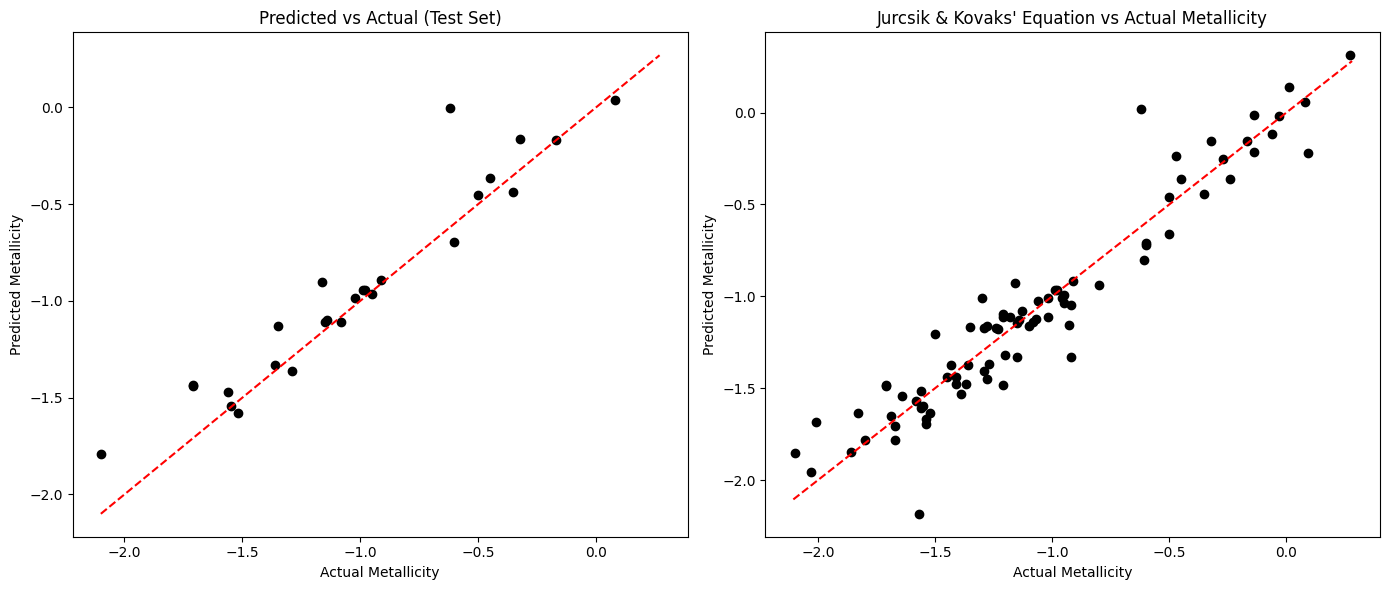

In [186]:
y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


Fe_on_H = blink_util.get_FoH(df, verbose=False)


axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

#Setting up Predicted vs. Actual for test data and the full set.

# Cross Validation
Here we use KFold and CV to measure the accuracy of the model

First we get the score for our first estimator

In [187]:
final_model = LinearRegression()

final_model.fit(X, y)
# TODO: try pairs of params


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Now we train our model using KFold splits with shuffled items and measure the scores

In [188]:

def get_metrics(estimator):
    kfold = KFold(n_splits=5, shuffle=True)

    scores = cross_val_score(estimator, X, y, cv=kfold, verbose=0)
    r2_scores = cross_val_score(estimator, X, y, cv=kfold, scoring='r2')
    mse_scores = -cross_val_score(estimator, X, y, cv=kfold, scoring='neg_mean_squared_error')

    print(f"CV Scores: {scores}")
    print("Cross-validated R^2 scores:", r2_scores)
    print("Average R^2:", np.mean(r2_scores))
    print("Cross-validated MSE:", mse_scores)
    print("Average MSE:", np.mean(mse_scores))

get_metrics(final_model)

CV Scores: [0.9538279  0.85960503 0.91262191 0.9071105  0.92310527]
Cross-validated R^2 scores: [0.94575753 0.7947814  0.94185052 0.94333403 0.84107507]
Average R^2: 0.8933597076370774
Cross-validated MSE: [0.01691449 0.02796366 0.03412458 0.02893344 0.04138719]
Average MSE: 0.029864672563353855


# Equations

In [189]:
#Attempt to get equation

m = model.coef_[0]      # slope
b = model.intercept_   # y-intercept

print(f"y = {m:.4f}x + {b:.4f}")

for i, coef in enumerate(model.coef_):
    print(f"b{i+1} = {coef}")

y = -5.1571x + -4.8315
b1 = -5.157078587728317
b2 = 1.2853702091156018


# Now we explore parameters which for $|$ coef $| > 0.1$

### We start by creating a new dataframe with all the parameters


In [190]:
test_df = pd.DataFrame()
test_df["period"] = df["period"]

append_amp_ratios(df, test_df)
append_phi_diff(df, test_df)

test_df["metallicity"] = df["metallicity"]
test_df

C:\Users\mewsi\AppData\Local\Temp\ipykernel_17884\2024139058.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[phi_name] = blink_util.twopi_normalize(phi_n1_row, phi_n2_row, coef=coef)
C:\Users\mewsi\AppData\Local\Temp\ipykernel_17884\1545814513.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df["metallicity"] = df["metallicity"]


,period,R_15/1,R_15/2,R_15/3,R_15/4,R_15/5,R_15/6,R_15/7,R_15/8,R_15/9,...,phi615,phi715,phi815,phi915,phi1015,phi1115,phi1215,phi1315,phi1415,metallicity
0,0.442266,0.013673,0.024404,0.041627,0.074576,0.130952,0.216749,0.382609,0.745763,1.760000,...,4.614941,3.935441,3.220427,3.290927,3.362612,3.348012,2.421097,1.430797,0.235182,-0.06
1,0.722753,0.003574,0.006977,0.010582,0.019449,0.036697,0.071006,0.131868,0.187500,0.255319,...,2.370341,1.772627,1.232312,0.905312,0.791297,1.017682,2.661868,3.070553,3.593053,-1.69
2,0.616915,0.004000,0.010063,0.020050,0.041667,0.101266,0.181818,0.163265,0.177778,0.235294,...,0.793485,3.899371,0.281771,2.803256,5.203056,1.159556,3.158641,5.277741,1.903241,-0.92
3,0.574337,0.015427,0.035088,0.045045,0.067114,0.117096,0.208333,0.520833,0.704225,1.562500,...,1.666485,5.505271,3.293571,1.375471,6.057056,4.062056,1.685856,5.734141,3.388841,-1.39
4,0.459303,0.001937,0.004153,0.005590,0.009184,0.012212,0.017208,0.025641,0.045455,0.046392,...,1.376600,5.211485,2.619285,0.064300,4.036685,1.736885,5.685771,3.827585,6.125671,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.015544,0.030760,0.043890,0.068182,0.119718,0.216102,0.401575,0.796875,1.888889,...,2.891971,5.933756,2.710656,5.964641,3.894241,1.268441,4.462727,1.267227,4.347012,-1.15
80,0.475607,0.002929,0.005355,0.008397,0.011727,0.019332,0.032448,0.055838,0.076389,0.127907,...,5.669112,3.911797,2.122097,0.173582,4.460568,2.653253,0.488738,4.916524,2.855609,-0.60
81,0.525791,0.018640,0.044483,0.054340,0.075342,0.108757,0.161088,0.246006,0.377451,0.553957,...,2.232985,2.046385,1.767571,1.353571,0.884771,0.499071,0.247771,0.095671,6.279841,-1.54
82,0.656908,0.003311,0.006742,0.010949,0.021127,0.046392,0.102273,0.160714,0.130435,0.115385,...,2.190971,4.686071,0.845471,2.972871,5.005756,0.679656,2.512856,3.964641,5.315541,-1.02


### We then create a new mode through an sk pipeline to get normalized coefficients  
We individually measure coefficients independent of other parameters so we can avoid interference from multilinear relations

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
      

coef_df = pd.DataFrame(columns=["Parameters", "Coefficients"])

model = make_pipeline(StandardScaler(), LinearRegression())

for param in test_df.drop(columns=["metallicity"]):

    X = test_df.filter([param])

    model.fit(X, y)
    normalized_coefficients = model.named_steps['linearregression'].coef_
    
    dat = {"Parameters": f"{param}", "Coefficients": normalized_coefficients[0]}

    coef_df.loc[len(coef_df)] = dat

# TODO: Need to stop growing dataframes as it is very innefficient, but for testing we'll stick with it

coef_df = coef_df.sort_values(
    by="Coefficients",
    key=lambda x: x.abs(),
    ascending=False
).reset_index(drop=True)

coef_df



,Parameters,Coefficients
0,period,-0.422627
1,R_2/1,0.266844
2,R_3/2,-0.229915
3,phi31,0.186834
4,phi313,-0.172347
...,...,...
292,phi211,-0.001903
293,phi510,0.001638
294,phi133,0.001021
295,phi71,-0.000991


### Now we filter out parameters with weakest coefficients

In [192]:
param_filter = []
def filter_params(coefficients: pd.DataFrame, filter_list: list, threshold: float):
    for i, row in coefficients.iterrows():
        greater = abs(row["Coefficients"])> threshold
        if greater:
            param_filter.append(row["Parameters"])
            print(row["Parameters"],row["Coefficients"])
filter_params(coef_df,param_filter, .1)


period -0.42262719377997365
R_2/1 0.26684386844455077
R_3/2 -0.2299150662551088
phi31 0.18683402249604403
phi313 -0.1723466575344392
phi39 0.16987792509480165
phi122 -0.16575550120648763
R_11/8 0.16414505955945005
R_8/7 -0.1575399641177704
R_12/8 0.15670186064859992
R_4/2 -0.15110383329235852
phi16 -0.14648388477723842
phi124 0.14479232339150852
phi13 -0.14290760444412567
phi21 0.14112727007345938
R_11/10 0.1399886316813135
phi310 0.13073550762616182
phi54 0.1302316765097591
R_10/8 0.12933569262397318
R_13/12 -0.12223117080009542
R_15/8 0.12154894445814828
phi131 0.12105786006120654
R_5/2 -0.12035149257722583
phi65 -0.11879138236374098
phi41 0.11795987138795225
R_9/7 -0.11577082039197868
phi413 -0.11394124653672326
phi73 0.1059852167723771
R_12/10 0.10458663148196348
R_6/5 0.10450910032188468
R_13/11 -0.10250491750320455
phi107 0.10136382018260297
phi1110 0.10127982276379811


### Then we filter out parameters with low statistical significance

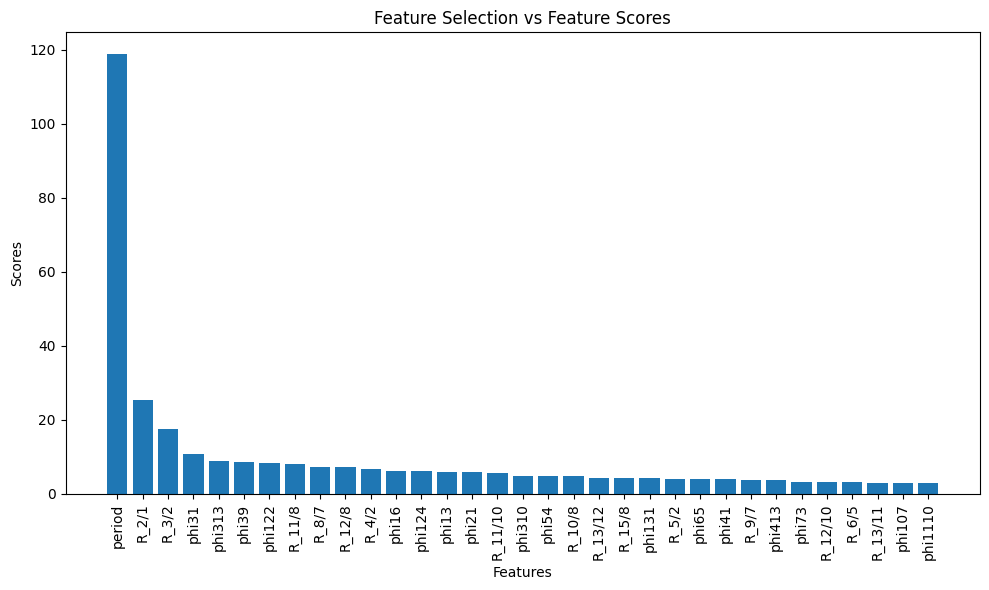

Selected Features:
Index(['period', 'R_2/1', 'R_3/2', 'phi31', 'phi313', 'phi39', 'phi122',
       'R_11/8'],
      dtype='str')


In [193]:
from sklearn.feature_selection import SelectKBest, f_regression

X = test_df.filter(param_filter)
y = jk_df["metallicity"] 


# measures P values along with F values for stat significance
feature_selector = SelectKBest(score_func=f_regression, k=8)
X_new = feature_selector.fit_transform(X, y)


selected_indices = feature_selector.get_support(indices=True)
selected_features = X.columns[selected_indices]

scores = feature_selector.scores_

plt.figure(figsize=(10, 6))
plt.bar(range(len(X.columns)), scores)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature Selection vs Feature Scores')
plt.tight_layout()
plt.show()

print("Selected Features:")
print(selected_features)



### Testing relationships to period
We know that for the equation used in the Jurcsik and Kovac paper on RR Lyrae is specifically a relation between period and Phi31 so we test period with other features

In [194]:
coef_df = pd.DataFrame(columns=["Parameters", "Coefficients"])

model = make_pipeline(StandardScaler(), LinearRegression())

for param in test_df.drop(columns=["metallicity"]):

    X = test_df.filter(["period",param])

    model.fit(X, y)
    normalized_coefficients = model.named_steps['linearregression'].coef_
    
    dat = {"Parameters": f"{param}", "Coefficients": normalized_coefficients[0]}

    coef_df.loc[len(coef_df)] = dat

coef_df = coef_df.sort_values(
    by="Coefficients",
    key=lambda x: x.abs(),
    ascending=False
).reset_index(drop=True)

coef_df

,Parameters,Coefficients
0,phi51,-0.565768
1,phi41,-0.549990
2,phi21,-0.523585
3,R_7/1,-0.522340
4,R_7/2,-0.520565
...,...,...
292,phi122,-0.409001
293,R_8/7,-0.407932
294,phi39,-0.404839
295,phi313,-0.404620


phi51 -0.5657679395024917
phi41 -0.5499901332737998
phi21 -0.5235853703791847
R_7/1 -0.522340203619069
R_7/2 -0.5205650985857305
R_6/1 -0.5185359903930921
R_8/1 -0.5182419612569746
R_6/4 -0.517699659438496
R_6/3 -0.5160672366503042
R_7/3 -0.5154778854356179
R_8/2 -0.5094160347034713
R_6/2 -0.5089185336095282
phi31 -0.5082378287268133
R_8/3 -0.5064273601917815
R_7/4 -0.5062147615407303
phi91 -0.5042613406581484
R_5/4 -0.4981214461919406
R_9/1 -0.4963294260016406
phi71 -0.49415281939004924
R_5/1 -0.4924981505532842
R_5/3 -0.49219743451472964
R_8/4 -0.4855161375505623
R_9/2 -0.48482491768043817
R_5/2 -0.47839374264581946
R_9/3 -0.477907702251399
R_6/5 -0.4745994120661702
R_10/1 -0.4734216885072772
phi81 -0.46913457490570404
R_10/2 -0.4672588404672958
R_4/1 -0.45867204153890273
R_11/2 -0.4578714922330811
R_11/1 -0.45753953467056707
R_10/3 -0.4561071866485151
R_15/7 -0.45316388009567127
R_4/3 -0.4510860161249903
R_13/7 -0.4497925104331736
R_3/1 -0.44931713101591786
R_4/2 -0.4480189890547312

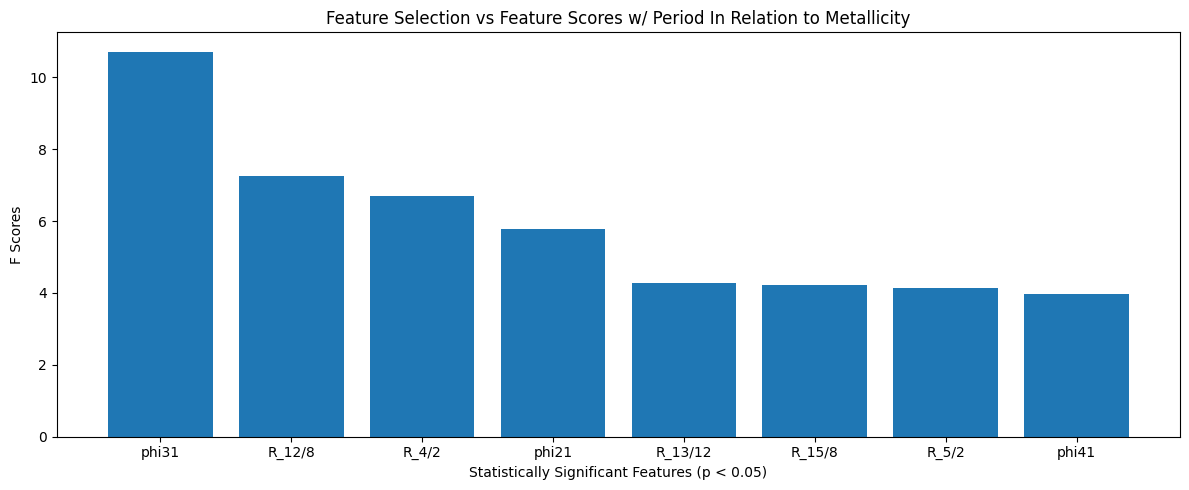

Statistically Significant Features:
     Feature    F Score   p-value
12     phi31  10.718329  0.001555
128   R_12/8   7.258511  0.008557
37     R_4/2   6.707503  0.011359
2      phi21   5.790542  0.018361
76   R_13/12   4.268402  0.041984
69    R_15/8   4.218442  0.043173
23     R_5/2   4.131568  0.045326
1      phi41   3.961141  0.049894


In [195]:
param_filter = []

filter_params(coef_df, param_filter, .4226) # use period coeff as threshold

X = test_df.filter(param_filter).drop(columns=["period"])


# Use all features first
feature_selector = SelectKBest(score_func=f_regression, k="all")
feature_selector.fit(X, y)

scores = feature_selector.scores_
p_values = feature_selector.pvalues_

results = pd.DataFrame({
    "Feature": X.columns,
    "F Score": scores,
    "p-value": p_values
})

# p value threshold
alpha = 0.05
significant_features = results[results["p-value"] < alpha]

significant_features = significant_features.sort_values(
    by="F Score", ascending=False
)

plot_features = significant_features["Feature"].values
plot_scores = significant_features["F Score"].values

plt.figure(figsize=(12, 5))
plt.bar(range(len(plot_features)), plot_scores)
plt.xticks(range(len(plot_features)), plot_features)
plt.xlabel('Statistically Significant Features (p < 0.05)')
plt.ylabel('F Scores')
plt.title('Feature Selection vs Feature Scores w/ Period In Relation to Metallicity')
plt.tight_layout()
plt.show()

print("Statistically Significant Features:")
print(significant_features)

# new filter from new params
significant_param_list = significant_features["Feature"].tolist()


# get rid of reciprocals first n > second n

Mean Absolute Error (MEA): 0.10942913971675335
Mean Squared Error (MRE): 0.030406364466982083
R^2 Score: 0.8888947017887381


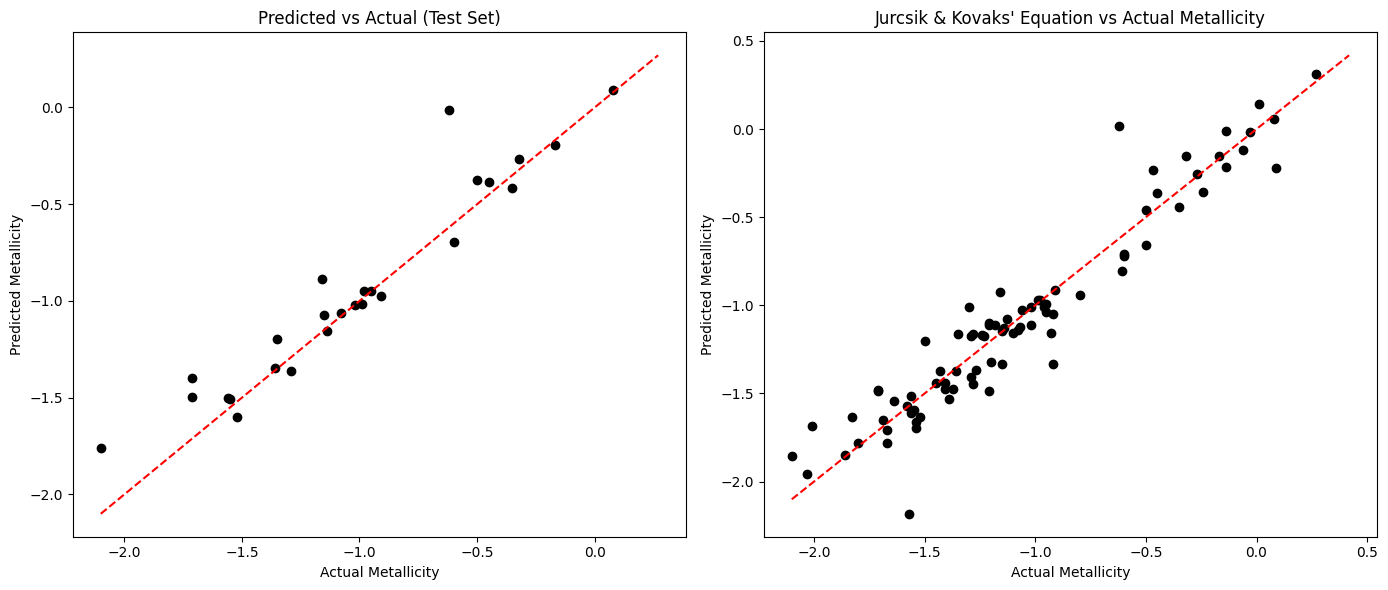

In [196]:

significant_param_list.append('period')
X = test_df.filter(significant_param_list)


model.fit(X,y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

model.fit(x_train, y_train)

y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


Fe_on_H = blink_util.get_FoH(df, verbose=False)


axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

### Now we test the model trained on our new filter

In [197]:
model.fit(X,y)

get_metrics(model)

CV Scores: [0.92667099 0.89108253 0.86559163 0.62875008 0.8866973 ]
Cross-validated R^2 scores: [0.86477714 0.84719904 0.92653394 0.82410628 0.92601078]
Average R^2: 0.8777254358429832
Cross-validated MSE: [0.0631042  0.02307437 0.0401151  0.02693813 0.0367348 ]
Average MSE: 0.0379933199133067
